In [1]:
import requests
from pprint import pprint
from tqdm import tqdm
import time
import pandas as pd
import numpy as np
import json

## Load data

In [15]:
%load_ext autoreload
%autoreload 2
from read_data import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
art_metadata_df, artist_metadata_df, invited_by_metadata,bidding_df, minting_df, listing_df, max_bid_df,total_artist_earning, total_buyer_spending = load_data()

loading data...


100%|██████████| 48059/48059 [00:33<00:00, 1441.02it/s]


N art re-listed: 1928
N art resold: 138
finished loading data...
stats...
N art minted: 50723
N art listed: 48059
N art sold: 15279
N creators: 15366
N buyers: 5531
N bids: 37013


# Query the Foundation and Twitter data

- below we provide the script required to crawl the data... 
- the functions below will help get the "latest" data on the platform. 
- the read_data script helps load the data. 

In [356]:
# function to use requests.post to make an API call to the subgraph url
def run_query(q):

    # endpoint where you are making the request
    request = requests.post('https://api.thegraph.com/subgraphs/name/f8n/fnd'
                            '',
                            json={'query': q})
    if request.status_code == 200:
        return request.json()
    else:
        raise Exception('Query failed. return code is {}.      {}'.format(request.status_code, query))

# given a token id return the metadata
def get_metadata(t_id):
    query = """
{
  nfts(where: {tokenId: \""""+str(t_id)+"""\" }) {
    tokenId
    dateMinted
    creator {
      id
    }
    owner {
      id
    }
    netSalesInETH
    netRevenueInETH
    isFirstSale
    nftHistory{
    event
    date
    amountInETH
    actorAccount{
    id
    }
    }
  }
}
"""
    result = run_query(query)
    return result['data']['nfts'][0]


In [168]:
nft_metadata = {}

### i.e. brute force call all of the minted token ids
for t_id in tqdm(range(0,20000)):
    try:
        nft_metadata[t_id] = get_metadata(t_id)
    except:
        continue


100%|██████████| 20000/20000 [1:13:27<00:00,  4.54it/s]


In [178]:
print("N art minted:", np.max(list(nft_metadata.keys())))

N art minted: 50724


In [180]:
with open('../new-data/nft_raw_data.txt', 'w') as outfile:
    json.dump(nft_metadata, outfile)

In [193]:
t = json.load(open('../new-data/nft_raw_data.txt','r'))
#t = dict(t)
print("N art minted:", len(list(t.keys())))

N art minted: 50723


# Organize Data

- take the raw data from above and organize it into readable form

In [196]:
# given a nft return the nft metadata, minting data, bidding data, listing data
def organize_dict(nft_data):
    
    # nft metadata
    nft_id = int(nft_data['tokenId'])
    owner_id = nft_data['owner']['id']
    creator_id = nft_data['creator']['id']
    mint_date = nft_data['dateMinted']
    is_sold = not nft_data['isFirstSale']
    net_artist_earning = nft_data['netRevenueInETH']
    selling_price = nft_data['netSalesInETH']
    
    metadata_tmp = pd.DataFrame({'token_id':[nft_id],'creator':[creator_id],
                                'is_sold':[is_sold],'net_artist_earn_eth':[net_artist_earning],
                                'selling_price_eth':[selling_price], 'owner':[owner_id]})
    mint_df_tmp = pd.DataFrame({'token_id':[nft_id],'mint_date':[mint_date]})
    
    
    # event history
    events = nft_data['nftHistory']
    
    bid_list_art_id = []
    bid_list_actor_id = []
    bid_list_eth = []
    bid_list_date = []
    bid_list_creator = []
    
    list_art_id = []
    list_user_id = []
    list_date = []
    list_eth = []
    
    for e in events:
        if e['event'] == 'Bid':
            bid_list_art_id.append(nft_id)
            bid_list_actor_id.append(e['actorAccount']['id'])
            bid_list_date.append(e['date'])
            bid_list_eth.append(e['amountInETH'])
            bid_list_creator.append(creator_id)
            
        if e['event'] == 'Listed':
            list_art_id.append(nft_id)
            list_user_id.append(e['actorAccount']['id'])
            list_date.append(e['date'])
            list_eth.append(e['amountInETH'])
    
    list_df_tmp = pd.DataFrame({'token_id':list_art_id,'creator':list_user_id,
                                'listing_date':list_date,'listing_amt':list_eth})
    bid_df_tmp = pd.DataFrame({'token_id':bid_list_art_id,'bidder_id':bid_list_actor_id,
                              'creator':bid_list_creator,'bidding_amt':bid_list_eth,
                              'bid_date':bid_list_date})
        
    return metadata_tmp, mint_df_tmp, list_df_tmp, bid_df_tmp    

In [195]:
nft_metadata_df = pd.DataFrame()
mint_df = pd.DataFrame()
list_df = pd.DataFrame()
bid_df = pd.DataFrame()

for v in tqdm(list(nft_metadata.values())):
    a, b, c, d = organize_dict(v)
        
    nft_metadata_df = nft_metadata_df.append(a, ignore_index = True)
    mint_df = mint_df.append(b, ignore_index = True)
    list_df = list_df.append(c, ignore_index = True)
    bid_df = bid_df.append(d, ignore_index = True)
    
bid_df.head()

100%|██████████| 50723/50723 [17:01<00:00, 49.68it/s] 


,token_id,bidder_id,creator,bidding_amt,bid_date
0,2.0,0xb188ee1daca51ce6b58ccf8a81ce4025a714bc73,0x2b65a808d0d5d54cdbb701b82d814374b812a4b8,0.43,1612394715
1,2.0,0x93730ce5ac9de1db9f3fbb73bf522a690629ccec,0x2b65a808d0d5d54cdbb701b82d814374b812a4b8,0.3735,1612378795
2,3.0,0x65c8c8b156a1d1a9488bd2be3798dfc417ecee45,0x376884df6fb55bfa319d703bc1ac5091ef479ff5,3.5,1612437649
3,3.0,0xc88ebc63c3126e9f37a46c1cf55b0e79c9cc20e2,0x376884df6fb55bfa319d703bc1ac5091ef479ff5,3,1612376558
4,3.0,0xeb4bd5231274aa4c2b97a4fa06bad9ecfcdad5e0,0x376884df6fb55bfa319d703bc1ac5091ef479ff5,1.1201,1612376298


In [202]:
### save data frames
mint_df.to_csv("../new-data/mint_data.csv", index = False)
bid_df.to_csv("../new-data/bid_data.csv", index = False)
list_df.to_csv("../new-data/list_data.csv", index = False)
nft_metadata_df.to_csv("../new-data/nft_metadata.csv", index = False)

# Get Foundation Follow Counts

- use Selenium to web crawl the data

In [220]:
creators_to_crawl = list(nft_metadata_df.creator.unique())
print("N creators:", len(creators_to_crawl))

N creators: 15366


In [240]:
### packages to load
import os
import time
import io
import requests
import pandas as pd
from tqdm import tqdm
import numpy as np
import networkx as nx

# selenium stuff
import selenium
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
#from webdriver_manager.firefox import FirefoxDriverManager
from selenium.common.exceptions import ElementClickInterceptedException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
from selenium.webdriver.common.keys import Keys

In [262]:
####
# get artists metadata
####

# given a artist page extract their metadata
def artist_metadata(x):

    page_link = 'https://foundation.app/' + str(x)
    # remove @ in front of id if needed
    driver.get(page_link)
    #driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    driver.execute_script("document.body.style.zoom='60 %'")

    time.sleep(2)

    artist_id = x

    # artist name
    artist_name = driver.find_element_by_xpath('/html/body/div/div[2]/div[4]/div[1]/div[2]/div/div[1]/div[1]/div/div').text
    artist_handle = driver.find_element_by_xpath('/html/body/div/div[2]/div[4]/div[1]/div[2]/div/div[1]/div[2]/div').text
    
    # update page link
    page_link = 'https://foundation.app/'+artist_handle
    
    artist_handle = artist_handle[1:]
    
    # about the artist
    about = driver.find_element_by_xpath('/html/body/div/div[2]/div[4]/div[1]/div[2]/div/div[2]/div[2]/div/div[2]/div[2]/div').text

    # web links
    elems = driver.find_elements_by_xpath("//a[@href]")
    twitter_link = ''
    instagram_link = ''

    for elem in elems:
        attr_name = elem.get_attribute("href")
        if 'instagram' in attr_name and 'foundation' not in attr_name:
            instagram_link = attr_name
        if 'twitter' in attr_name and 'withfnd' not in attr_name:
            twitter_link = attr_name
    
    n_following = driver.find_element_by_xpath('/html/body/div/div[2]/div[4]/div[1]/div[2]/div/div[2]/div[1]/div[2]/div[1]/div/div[1]').text
    n_followers = driver.find_element_by_xpath('/html/body/div/div[2]/div[4]/div[1]/div[2]/div/div[2]/div[1]/div[2]/div[2]/div/div[1]').text

    # get the invited artist
    invited_artist_page = driver.find_elements_by_class_name('css-h6hd16')
    if len(invited_artist_page)>0:
        invited_artist_page = invited_artist_page[0].get_attribute('href')
        invited_artist_page = list(invited_artist_page)
        idx = len(invited_artist_page) - 1 - invited_artist_page[::-1].index('/')
        invited_artist_name = ''.join(invited_artist_page[idx+1:])
        invited_artist_name = invited_artist_name[1:]
    else:
        invited_artist_name = ''

    
    return pd.DataFrame({'artist_id':[x],'artist_name':[artist_name],'artist_handle':[artist_handle],
                         'page_link':[page_link],'description':[about],'invited_by':[invited_artist_name],
                        'twitter':[twitter_link],'instagram':[instagram_link],
                        'n_following':[n_following],'n_followers':[n_followers]})



In [309]:
chrome_options = webdriver.ChromeOptions()
prefs = {"profile.managed_default_content_settings":{"images": 0},
        "profile.default_content_settings":{"images": 0}}

chrome_options.add_experimental_option("prefs", prefs)

## web driver
driver = webdriver.Chrome(ChromeDriverManager().install())




====== WebDriver manager ======
Current google-chrome version is 91.0.4472
Get LATEST driver version for 91.0.4472
Driver [/Users/kishorevasan/.wdm/drivers/chromedriver/mac64/91.0.4472.101/chromedriver] found in cache


In [282]:
#artist_metadata_df = pd.DataFrame()

for a in tqdm(creators_to_crawl):
    try:
        if a in artist_metadata_df.artist_id.tolist() and artist_metadata_df[artist_metadata_df.artist_id == a].n_following.tolist()[0] == '':
            artist_metadata_df = artist_metadata_df.append(artist_metadata(a))
    except:
        continue

print("N artists crawled:", artist_metadata_df.artist_id.nunique())
artist_metadata_df.head()

100%|██████████| 15366/15366 [1:45:48<00:00,  2.42it/s]   

N artists crawled: 14856


,artist_id,artist_name,artist_handle,page_link,description,invited_by,twitter,instagram,n_following,n_followers
0,0xcf0949bf6d2adf8032260fd08039c879cf71c128,Sarah Zucker,thesarahshow,https://foundation.app/@thesarahshow,artist + writer 🅞🅟🅔🅝🅘🅝🅖 🅟🅞🅡🅣🅐🅛🅢 between cuttin...,,https://twitter.com/thesarahshow,https://instagram.com/thesarahshow,8,165
0,0x2b65a808d0d5d54cdbb701b82d814374b812a4b8,Michael Shillingburg,shilly,https://foundation.app/@shilly,Designer & 3D illustrator creating interactive...,,,https://instagram.com/planet.gif,2,141
0,0x376884df6fb55bfa319d703bc1ac5091ef479ff5,Sven Eberwein,sveneberwein,https://foundation.app/@sveneberwein,Working at the intersection of computer graphi...,,https://twitter.com/sven_eberwein,,0,99
0,0x080b6202c0a5c464799e1e5a4aa7325eace9a5e1,Jessica Ticchio,jessicaticchio,https://foundation.app/@jessicaticchio,Jessica Ticchio is a multidisciplinary creativ...,,https://twitter.com/jessticchio_art,https://instagram.com/jessicaticchio,47,300
0,0x87042da39c06b0f85b435e5ec8ce2b15ec7bd700,HY𝒜M,hyam,https://foundation.app/@hyam,hyam is an experimental artist working with mi...,,https://twitter.com/hyumankind,https://instagram.com/hyumankind,6,1371


In [298]:
#artist_metadata_df.to_csv("../new-data/artist_metadata.csv", index = False)

## Crawl Invited Artists 

- get the metadata about the invited artists.

In [302]:
artist_metadata_df[~artist_metadata_df.invited_by.isna()]

,artist_id,artist_name,artist_handle,page_link,description,invited_by,twitter,instagram,n_following,n_followers
62,0xa8a33539960ef4779cb0eceded8002c1ecd40582,Collin LaFleche,usually,https://foundation.app/@usually,Collin LaFleche is a filmmaker from New York.,jessewldn,https://twitter.com/collinlafleche,NaN,1.0,9.0
64,0x63a811487f7a84ec2dfcd1851e24acd75d2431c8,Griffin Frazen,griffinfrazen,https://foundation.app/@griffinfrazen,Griffin Frazen is an Emmy award winning design...,jessewldn,NaN,NaN,0.0,4.0
66,0x48f0efe12a93d43fbf81d1fff7c22b4b0a06661e,Bella - Piano and the Fox,pianoandthefox,https://foundation.app/@pianoandthefox,"U.K based passionate 3D artist, animator, and ...",wonderkatzi,https://twitter.com/pianoandthefox,NaN,12.0,114.0
68,0x01df805afe4325d7ebab11d2a41433eb6e278631,ZiP Visuals,zip_visuals,https://foundation.app/@zip_visuals,"I am a self-taught 3D artist from Brooklyn, Ne...",peenpoon,https://twitter.com/zip_visuals,NaN,22.0,46.0
71,0x7c1ab760a4126e827dd3ed88c2baf21ee4de5f3b,Aaron Leroy,onderwish,https://foundation.app/@onderwish,🟨Spreading art across the cosmos 🎨🚀\n🟡Working ...,sergeposters,https://twitter.com/onderwish,NaN,2.0,280.0
...,...,...,...,...,...,...,...,...,...,...
16548,0xd8cd983d81f38e620389f3204f67a348dbf051c5,bruce getty,gettyartistsf,https://foundation.app/@gettyartistsf,Oh boy! My name is Bruce Getty. I am a Bay Are...,jstnptrs,NaN,https://instagram.com/gettyphotography,4.0,8.0
16549,0x19c1c2b4f2444ad04eb535cdab188c901bf9ec15,Master Control Program,mastercontrolprogram,https://foundation.app/@mastercontrolprogram,"I touch on minimalist compositions, retro-futu...",Boxhead,https://twitter.com/MCP_Art,https://instagram.com/master_control_program,111.0,100.0
16550,0x1d8d0c731fd00f39a5f7be7b3cb4d8785947724f,Marco Brambillla,marcobrambilla,https://foundation.app/@marcobrambilla,Marco Brambilla is an artist. His pioneering u...,dom,https://twitter.com/BrambillaStudio,https://instagram.com/marcobrambillastudio,35.0,579.0
16551,0x7a8f54fc16511ec86429e6197b7835ad6047a6ef,Penelope,pmnoe,https://foundation.app/@pmnoe,PM is a multimedia artist who channels postmod...,zendamage,https://twitter.com/penelopeMNT,https://instagram.com/pmnoeart,86.0,98.0


In [305]:
invited_by_list = list(artist_metadata_df[~artist_metadata_df.invited_by.isna()].invited_by.unique())

invited_by_list = [i for i in invited_by_list if i not in artist_metadata_df.artist_handle.tolist()]
len(invited_by_list)

1643

In [329]:
####
# get artists metadata
####

# given a artist page extract their metadata
def artist_metadata(x):

    page_link = 'https://foundation.app/' + str(x)
    # remove @ in front of id if needed
    driver.get(page_link)
    #driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    driver.execute_script("document.body.style.zoom='60 %'")

    time.sleep(2)
    
    # blockchain address
    btn = driver.find_element_by_xpath('/html/body/div/div[2]/div[4]/div[1]/div[1]/div/div/div[3]')
    chains = ActionChains(driver)
    chains.click(btn).perform()
    chains.send_keys(Keys.CONTROL + 'c').perform()
    artist_id = pyperclip.paste()

    # artist name
    artist_name = driver.find_element_by_xpath('/html/body/div/div[2]/div[4]/div[1]/div[2]/div/div[1]/div[1]/div/div').text
    artist_handle = driver.find_element_by_xpath('/html/body/div/div[2]/div[4]/div[1]/div[2]/div/div[1]/div[2]/div').text
    
    # update page link
    page_link = 'https://foundation.app/'+artist_handle
    
    artist_handle = artist_handle[1:]
    
    # about the artist
    about = driver.find_element_by_xpath('/html/body/div/div[2]/div[4]/div[1]/div[2]/div/div[2]/div[2]/div/div[2]/div[2]/div').text

    # web links
    elems = driver.find_elements_by_xpath("//a[@href]")
    twitter_link = ''
    instagram_link = ''

    for elem in elems:
        attr_name = elem.get_attribute("href")
        if 'instagram' in attr_name and 'foundation' not in attr_name:
            instagram_link = attr_name
        if 'twitter' in attr_name and 'withfnd' not in attr_name:
            twitter_link = attr_name
    
    n_following = driver.find_element_by_xpath('/html/body/div/div[2]/div[4]/div[1]/div[2]/div/div[2]/div[1]/div[2]/div[1]/div/div[1]').text
    n_followers = driver.find_element_by_xpath('/html/body/div/div[2]/div[4]/div[1]/div[2]/div/div[2]/div[1]/div[2]/div[2]/div/div[1]').text

    # get the invited artist
    invited_artist_page = driver.find_elements_by_class_name('css-h6hd16')
    if len(invited_artist_page)>0:
        invited_artist_page = invited_artist_page[0].get_attribute('href')
        invited_artist_page = list(invited_artist_page)
        idx = len(invited_artist_page) - 1 - invited_artist_page[::-1].index('/')
        invited_artist_name = ''.join(invited_artist_page[idx+1:])
        invited_artist_name = invited_artist_name[1:]
    else:
        invited_artist_name = ''

    
    return pd.DataFrame({'artist_id':[artist_id],'artist_name':[artist_name],'artist_handle':[artist_handle],
                         'page_link':[page_link],'description':[about],'invited_by':[invited_artist_name],
                        'twitter':[twitter_link],'instagram':[instagram_link],
                        'n_following':[n_following],'n_followers':[n_followers]})


In [ ]:
btn = driver.find_element_by_xpath('/html/body/div/div[2]/div[4]/div[1]/div[1]/div/div/div[3]')
ActionChains = ActionChains(driver)
ActionChains.double_click(btn).perform()
ActionChains.send_keys(Keys.CONTROL + 'c').perform()
text = pyperclip.paste()
print(text)

In [331]:
# crawl the invited people

####
## Remember to get the ether wallet id of these people
####


invited_by_metadata_df = pd.DataFrame()

for a in tqdm(invited_by_list):
    try:
        invited_by_metadata_df = invited_by_metadata_df.append(artist_metadata(a))
    except:
        continue

print("N artists crawled:", invited_by_metadata_df.artist_id.nunique())
invited_by_metadata_df.head()

100%|██████████| 1643/1643 [2:04:05<00:00,  4.53s/it]  

N artists crawled: 1469


,artist_id,artist_name,artist_handle,page_link,description,invited_by,twitter,instagram,n_following,n_followers
0,0xe7925D190aea9279400cD9a005E33CEB9389Cc2b,Jesse Walden,jessewldn,https://foundation.app/@jessewldn,variant.fund,,https://twitter.com/jessewldn,,3,54
0,0xb88ba009241c4ae57A265E8bD1932E41B20e5570,Adam Lisagor,adamlisagor,https://foundation.app/@adamlisagor,sandwich.co,,,,6,135
0,0x11c75F3480E23755ee25273e1344875499260c6e,Sam Clover,planttdaddii,https://foundation.app/@planttdaddii,Sam Clover aka PLANTTDADDII is a digital sculp...,,https://twitter.com/planttdaddii,https://instagram.com/planttdaddii,15,384
0,0x7d42611012FDbE366Bf4A0481FC0E1aBf15E245A,Jeff Davis,jeffgdavis,https://foundation.app/@jeffgdavis,Artist / CCO at Art Blocks / Founder at Davis ...,jeffgdavis,https://twitter.com/jeffgdavis,,20,32
0,0xfA3A28bc7BEedf3E196B0EfB8804313c285B33dC,ATM,atm,https://foundation.app/@atm,"Dillon ""ATM"" is a new media artist who tells h...",,https://twitter.com/dillonatm,https://instagram.com/dillonatm,32,692


In [334]:
#invited_by_metadata_df.to_csv("../new-data/invited_by_metadata.csv", index = False)

In [324]:
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
import pyperclip

In [321]:
btn = driver.find_element_by_xpath('/html/body/div/div[2]/div[4]/div[1]/div[1]/div/div/div[3]')
ActionChains = ActionChains(driver)
ActionChains.double_click(btn).perform()
ActionChains.send_keys(Keys.CONTROL + 'c').perform()
text = pyperclip.paste()
print(text)


0xe7925D190aea9279400cD9a005E33CEB9389Cc2b


# Crawl Twitter

In [339]:
invited_by_metadata_df[invited_by_metadata_df.twitter !=''].head()

,artist_id,artist_name,artist_handle,page_link,description,invited_by,twitter,instagram,n_following,n_followers
0,0xe7925D190aea9279400cD9a005E33CEB9389Cc2b,Jesse Walden,jessewldn,https://foundation.app/@jessewldn,variant.fund,,https://twitter.com/jessewldn,,3,54
0,0x11c75F3480E23755ee25273e1344875499260c6e,Sam Clover,planttdaddii,https://foundation.app/@planttdaddii,Sam Clover aka PLANTTDADDII is a digital sculp...,,https://twitter.com/planttdaddii,https://instagram.com/planttdaddii,15,384
0,0x7d42611012FDbE366Bf4A0481FC0E1aBf15E245A,Jeff Davis,jeffgdavis,https://foundation.app/@jeffgdavis,Artist / CCO at Art Blocks / Founder at Davis ...,jeffgdavis,https://twitter.com/jeffgdavis,,20,32
0,0xfA3A28bc7BEedf3E196B0EfB8804313c285B33dC,ATM,atm,https://foundation.app/@atm,"Dillon ""ATM"" is a new media artist who tells h...",,https://twitter.com/dillonatm,https://instagram.com/dillonatm,32,692
0,0x7c1ab760a4126E827dD3eD88C2BaF21EE4de5F3B,Aaron Leroy,onderwish,https://foundation.app/@onderwish,🟨Spreading art across the cosmos 🎨🚀\n🟡Working ...,sergeposters,https://twitter.com/onderwish,,2,281


In [340]:
# import the module
import tweepy
  
# assign the values accordingly
# Add your API key here
consumer_key = ""

# Add your API secret key here
consumer_secret = ""


access_token = ""
access_token_secret = ""
  
# authorization of consumer key and consumer secret
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
  
# set access to user's access key and access secret 
auth.set_access_token(access_token, access_token_secret)
  
# calling the api 
api = tweepy.API(auth,wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [341]:
# given a user return the user metadata
def get_twitter_metadata(x):
    
    user = api.get_user(x)

    location = user.location
    user_bio = user.description
    profile_location = user.profile_location
    followers_count = user.followers_count
    following_count = user.friends_count
    
    created_at = user.created_at
    
    verified = user.verified
    
    #latest_tweet = user.status
    
    #status_dict = latest_tweet._json
    
#    place_from_tweet = status_dict['place']
    
    return pd.DataFrame({'user_name':[x],'bio':[user_bio], 'created_at':[created_at],'location':[location],
                         'profile_location':[profile_location], 'followers_count':[followers_count],
                         'following_count':[following_count], 'verified':[verified]})



In [348]:
len(artist_metadata_df[~artist_metadata_df.twitter.isna()].twitter.unique())

13487

In [350]:
twitter_urls = artist_metadata_df[~artist_metadata_df.twitter.isna()].twitter.tolist()
print("N twitter profiles:", len(twitter_urls))


twitter_df = pd.DataFrame()
counter = 0

n_users_not_found = 0
for u in tqdm(twitter_urls):  
    u = list(u)
    idx = len(u) - 1 - u[::-1].index('/')
    u = ''.join(u[idx+1:])

    counter +=1
    try:
        twitter_df = twitter_df.append(get_twitter_metadata(u), ignore_index = True)
    except:
        n_users_not_found +=1
        continue

print("N users crawled:", len(twitter_df))
print("N users not found:", n_users_not_found)
twitter_df.head()

  0%|          | 0/13487 [00:00<?, ?it/s]

N twitter profiles: 13487


100%|██████████| 13487/13487 [3:35:14<00:00,  1.04it/s]    

N users crawled: 13155
N users not found: 332


,user_name,bio,created_at,location,profile_location,followers_count,following_count,verified
0,thesarahshow,artist + writer 🅞🅟🅔🅝🅘🅝🅖 🅟🅞🅡🅣🅐🅛🅢 between cuttin...,2011-02-26 00:38:02,thesarahshow.eth,None,8578,1016,False
1,sven_eberwein,"Works of the internet, by the internet, for th...",2020-06-12 17:06:09,Los Angeles,None,2228,1564,False
2,jessticchio_art,3D Artist creating boundless dreamscapes & vir...,2021-01-10 06:59:02,"Sydney, New South Wales",None,495,415,False
3,hyumankind,✧ 𝔡𝔢𝔷𝔦𝔤𝔫 ✧ @macro_hq,2011-01-06 05:29:54,"San Francisco, CA",None,14108,2695,False
4,FrancoiseGamma,https://t.co/xCZ5E9VBTu\nhttps://t.co/7L8WDLpa...,2019-12-24 11:11:54,Internet,None,1311,364,False


In [351]:
twitter_df.to_csv("../new-data/artist_twitter_metadata.csv", index = False)

In [353]:
twitter_urls = invited_by_metadata_df[invited_by_metadata_df.twitter!= ''].twitter.tolist()
print("N twitter profiles:", len(twitter_urls))

twitter_df = pd.DataFrame()
counter = 0

n_users_not_found = 0
for u in tqdm(twitter_urls):  
    u = list(u)
    idx = len(u) - 1 - u[::-1].index('/')
    u = ''.join(u[idx+1:])

    counter +=1
    try:
        twitter_df = twitter_df.append(get_twitter_metadata(u), ignore_index = True)
    except:
        n_users_not_found +=1
        continue

print("N users crawled:", len(twitter_df))
print("N users not found:", n_users_not_found)
twitter_df.head()

  0%|          | 0/1339 [00:00<?, ?it/s]

N twitter profiles: 1339


100%|██████████| 1339/1339 [17:19<00:00,  1.29it/s]   

N users crawled: 1301
N users not found: 38


,user_name,bio,created_at,location,profile_location,followers_count,following_count,verified
0,jessewldn,"founder @variantfund; via @a16z, @spotify, @me...",2009-03-24 01:50:46,New York,None,22665,1287,False
1,planttdaddii,🌕🔶🟩🟣🌕 🕳ᵗʰⁱˢ ⁱˢ ᵃˡˡ ᶠᵒʳ ʸᵒᵘ ╹◡╹,2019-01-17 08:08:21,"Seattle, WA",None,3660,378,False
2,jeffgdavis,Artist / CCO @artblocks_io / Founder @davisedi...,2007-11-21 06:11:59,"Tempe, AZ, USA",None,3104,896,False
3,dillonatm,#AKU 22 - he/him. visionary. new media artist....,2012-12-07 15:54:35,"Nashville, TN",None,3232,1000,False
4,onderwish,🟨Spreading art across the cosmos 🎨🚀\n⚪Explorin...,2016-02-27 21:56:55,Montreal,None,573,502,False


In [354]:
#twitter_df.to_csv("../new-data/invited_by_twitter_metadata.csv", index = False)

# Descriptive Plots

In [203]:
list_df['list_dt'] = list_df.listing_date.apply(lambda x: datetime.utcfromtimestamp(int(x)))
list_df['list_d'] = list_df.list_dt.apply(lambda x: x.date())
list_df.head()

,token_id,creator,listing_date,listing_amt,list_dt,list_d
0,2.0,0xb188ee1daca51ce6b58ccf8a81ce4025a714bc73,1622312534,2.5,2021-05-29 18:22:14,2021-05-29
1,2.0,0x2b65a808d0d5d54cdbb701b82d814374b812a4b8,1611689577,0.373468,2021-01-26 19:32:57,2021-01-26
2,3.0,0x376884df6fb55bfa319d703bc1ac5091ef479ff5,1611272958,1.12,2021-01-21 23:49:18,2021-01-21
3,4.0,0x080b6202c0a5c464799e1e5a4aa7325eace9a5e1,1611286202,1.75,2021-01-22 03:30:02,2021-01-22
4,5.0,0x87042da39c06b0f85b435e5ec8ce2b15ec7bd700,1611292587,0.1,2021-01-22 05:16:27,2021-01-22


In [204]:
first_list_df = list_df.groupby('token_id').list_d.min().to_frame()
first_list_df['tokenid'] = first_list_df.index
first_list_df.index = range(len(first_list_df))
first_list_df.head()

,list_d,tokenid
0,2021-01-26,2.0
1,2021-01-21,3.0
2,2021-01-22,4.0
3,2021-01-22,5.0
4,2021-01-22,6.0


In [205]:
n_list_date = first_list_df.list_d.value_counts().to_frame()
n_list_date['d'] = n_list_date.index
n_list_date.index = range(len(n_list_date))
n_list_date = n_list_date.sort_values('d')
n_list_date.head()

,list_d,d
146,1,2021-01-21
141,6,2021-01-22
144,3,2021-01-23
143,4,2021-01-24
145,2,2021-01-25


In [206]:
n_list_date.d.max()

datetime.date(2021, 6, 18)

In [207]:
import matplotlib.pyplot as plt

In [209]:
def get_moving_average(x):
    
    moving_averages = []
    for i in range(len(x)):
        if i == 0:
            this_window = x[:4]
        if i == 1:
            this_window = x[i-1:5]
        elif i == 2:
            this_window = x[i-2:6]
        else:
            this_window = x[i-3:i+4]
        #print(this_window)
        moving_averages.append(np.mean(this_window))
    return moving_averages


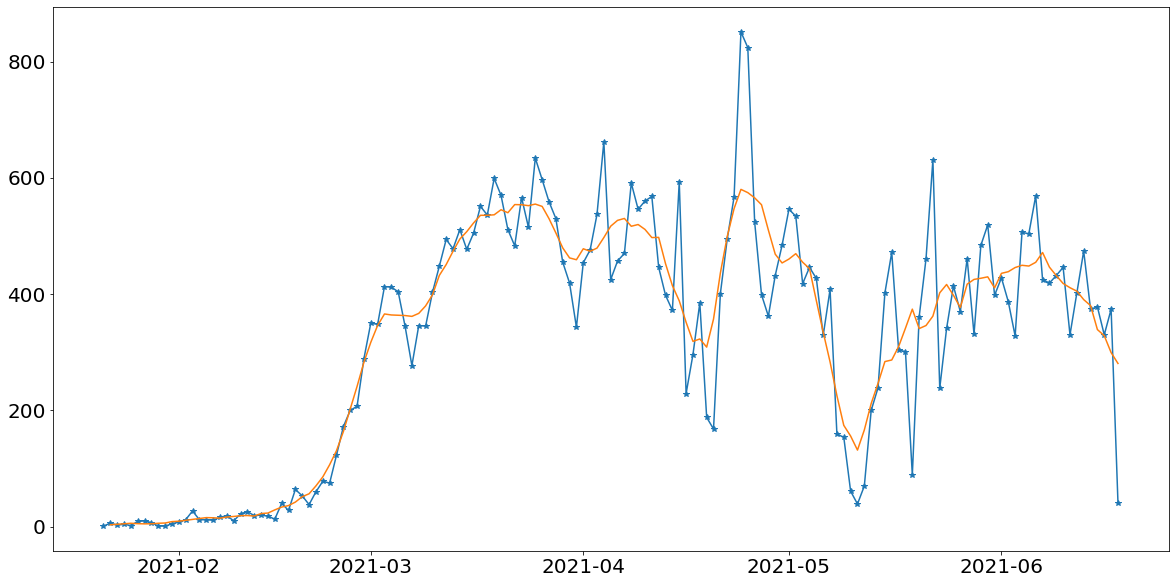

In [214]:
fig = plt.figure(figsize=(20,10))
plt.plot(n_list_date.d, n_list_date.list_d, marker='*')

y = get_moving_average(n_list_date.list_d)
plt.plot(n_list_date.d, y)
plt.tick_params(axis='both',which='major',labelsize=20)
plt.show()